In [146]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sample = pd.read_csv('sample_submission.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [147]:
train.shape

(30001, 12)

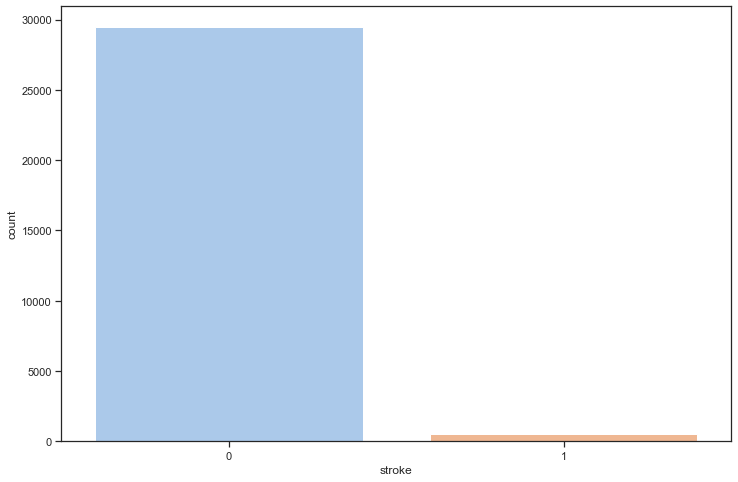

In [148]:
sns.countplot(x='stroke', data = train)
plt.show()

So,our classes are imbalanced

There is also missing data in some columns

In [149]:
for i in train.columns:
    print(i, (pd.isnull(train[i])).sum() )

id 0
gender 0
age 0
hypertension 0
heart_disease 0
ever_married 0
work_type 0
Residence_type 0
avg_glucose_level 0
bmi 1017
smoking_status 9176
stroke 0


In [150]:
#train = train.dropna()

'bmi' is a numeric column means we can fill it with the mean value; 
'smoking status' is filled by string 'nan'


In [151]:
mean_bmi = train['bmi'].mean()
train['bmi'] = train['bmi'].fillna(mean_bmi)
test['bmi'] = test['bmi'].fillna(mean_bmi)

train['smoking_status'] = train['smoking_status'].fillna('nan')
test['smoking_status'] = test['smoking_status'].fillna('nan')

In [152]:
print(train['gender'].unique())

['Male' 'Female' 'Other']


In [153]:
train['gender'].value_counts()

Female    17676
Male      12315
Other        10
Name: gender, dtype: int64

??? okay

Also we have to convert data to dummy variables

In [154]:
train_new = pd.get_dummies(train)
test_new = pd.get_dummies(test)
#all_feat = train_new.columns
train_new.head()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_nan,smoking_status_never smoked,smoking_status_smokes
0,30669,3.0,0,0,95.12,18.0,0,0,1,0,...,0,0,0,1,1,0,0,1,0,0
1,30468,58.0,1,0,87.96,39.2,0,0,1,0,...,0,1,0,0,0,1,0,0,1,0
2,16523,8.0,0,0,110.89,17.6,0,1,0,0,...,0,1,0,0,0,1,0,1,0,0
3,56543,70.0,0,0,69.04,35.9,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
4,46136,14.0,0,0,161.28,19.1,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0


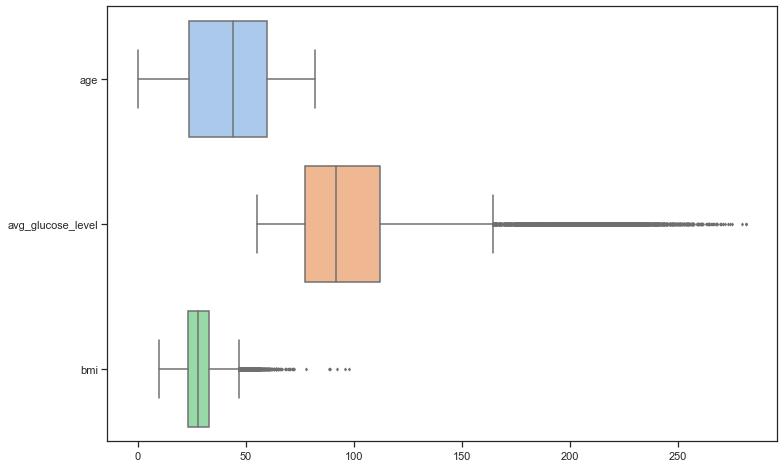

In [155]:
dat = train_new[["age","avg_glucose_level","bmi"]]
sns.boxplot(orient = "h", data=dat, fliersize = 2)

So, boxplot shows that 'bmi' and 'avg_glucose_level' have outliers. 

In [156]:
train_final = train_new[train_new["bmi"]<2*train_new["bmi"].mean()]
train_final = train_final[train_final["avg_glucose_level"]<2*train_final["avg_glucose_level"].mean()]

In [157]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

ROC metric for binary classification with imbalanced classes. KFold strategy for train data separation.

In [158]:
def cross_validation_for_roc_auc( clf, X, y ,cv=5):
    X = np.array(X.copy())
    y = np.array(y.copy())
    kf = KFold(n_splits=cv)
    kf.get_n_splits(X)
    scores = []
    for train_index, test_index in kf.split(X):
        #print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        clf.fit(X_train, y_train)
        prediction_on_this_fold = clf.predict_proba(X_test)[:,1]
        score = roc_auc_score(y_score=prediction_on_this_fold, y_true=y_test)
        scores.append(score)
    
    return scores# ROC-score on each fold

In [159]:
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import numpy as np

In [160]:
models = [
    SGDClassifier(loss='log'),
    #LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier()
]
all_features = train_final.columns

In [161]:
for model in models:
    features_scores = {}
    print('model')

    for f in all_features:
        scores = cross_validation_for_roc_auc(model, train_final[[f]] , train_final['stroke'])
        print(f,  np.mean(scores))
        features_scores[f] = np.mean(scores)

model
id 0.499892086159885
age 0.8423541623392954
hypertension 0.5809088488953011
heart_disease 0.5680378189697567
avg_glucose_level 0.49518430152865134
bmi 0.4725613211682493
stroke 1.0
gender_Female 0.5192675620993079
gender_Male 0.49209351996975315
gender_Other 0.5001799600662941
ever_married_No 0.6281026079431588
ever_married_Yes 0.6281026079431588
work_type_Govt_job 0.4877640920529389
work_type_Never_worked 0.5020325305840154
work_type_Private 0.5057124406645539
work_type_Self-employed 0.5762066933371766
work_type_children 0.572601178758118
Residence_type_Rural 0.4978170571804503
Residence_type_Urban 0.48642126340142877
smoking_status_formerly smoked 0.5578969872800652
smoking_status_nan 0.5552055968938265
smoking_status_never smoked 0.5040757666495722
smoking_status_smokes 0.5013255407932486
model
id 0.4977846736009047
age 0.8292070074940255
hypertension 0.5809088488953011
heart_disease 0.5680378189697567
avg_glucose_level 0.4900107411484488
bmi 0.5858948282318505
stroke 1.0
gend

C:\Users\MI\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


id 0.4959701051349844
age 0.8306628325332046
hypertension 0.5809088488953011
heart_disease 0.5680378189697567
avg_glucose_level 0.4942186186134503
bmi 0.5895983707685856
stroke 1.0
gender_Female 0.5192675620993079
gender_Male 0.49209351996975315
gender_Other 0.5001799600662941
ever_married_No 0.6281026079431588
ever_married_Yes 0.6281026079431588
work_type_Govt_job 0.4854725594455531
work_type_Never_worked 0.5020325305840154
work_type_Private 0.47420063496086395
work_type_Self-employed 0.5762066933371766
work_type_children 0.572601178758118
Residence_type_Rural 0.48642126340142877
Residence_type_Urban 0.48642126340142877
smoking_status_formerly smoked 0.5578969872800652
smoking_status_nan 0.5552055968938265
smoking_status_never smoked 0.5084442277545836
smoking_status_smokes 0.505752837368345


roc-auc value about 0.5 means that classifier works randomly. despite the low value at 'avg_glucose_level', I think it should also be taken into account

In [162]:
features = [ 'age', 'hypertension', 'heart_disease', 'avg_glucose_level',
       'bmi', 'ever_married_No',
        'ever_married_Yes', 'work_type_Self-employed',
      'work_type_children']

LogisticRegression

10 0.6670829077003102
20 0.84700734790695
30 0.8474007664626549
40 0.8474007664626549
50 0.8474007664626549
60 0.8474007664626549
70 0.8474007664626549
80 0.8474007664626549
90 0.8474007664626549


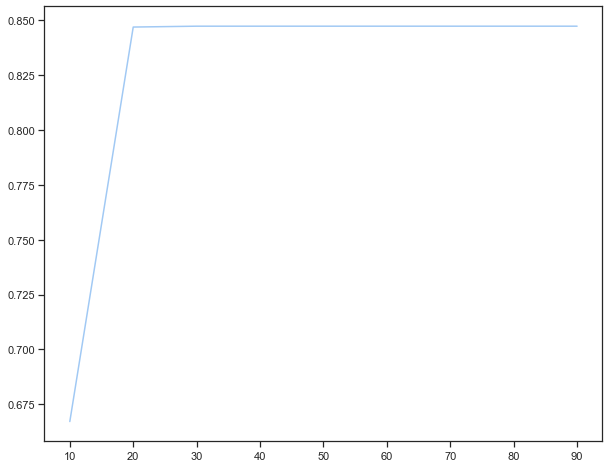

In [171]:
import warnings
warnings.filterwarnings('ignore')
x = []
y1 = []

for num in range(10,100,10):
    model = LogisticRegression(max_iter = num)
    scores_target = cross_validation_for_roc_auc(model, train_final[features] , train_final['stroke'])
    x.append(num)
    y1.append(np.mean(scores_target))
    print(num, np.mean(scores_target))
fig, ax = plt.subplots(figsize=(10,8),)
plt.plot(x, y1, label='target')
plt.show()

1 0.3254828445109746
2 0.32636808752534535
3 0.32955119814144945
4 0.4493413735785966
5 0.5507143815482948
6 0.546862867119911
7 0.6589477837217347
8 0.6469189404303541
9 0.6731698452764047
10 0.6670829077003102
11 0.7018388819012997
12 0.751209607264066
13 0.7610106162291744
14 0.8040041591866436
15 0.8297780883964749
16 0.8292626923658375
17 0.84268909285045
18 0.8471935680405936
19 0.8466625698479439


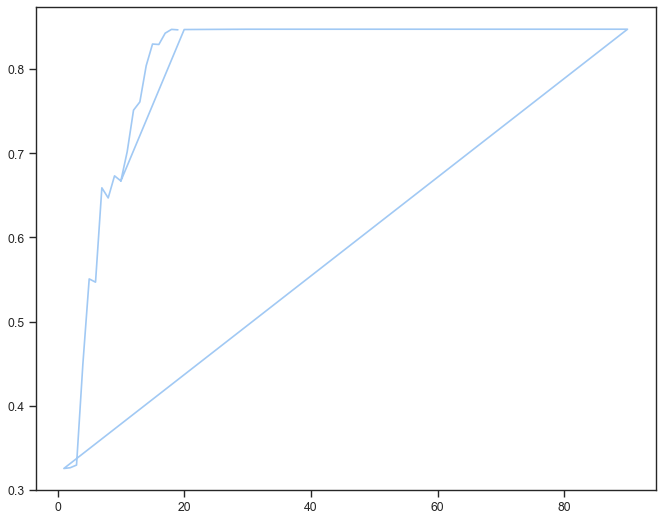

In [172]:
for num in range(1,20):
    model = LogisticRegression(max_iter = num)
    scores_target = cross_validation_for_roc_auc(model, train_final[features] , train_final['stroke'])
    x.append(num)
    y1.append(np.mean(scores_target))
    print(num, np.mean(scores_target))
fig, ax = plt.subplots(figsize=(10,8), dpi=80)
plt.plot(x, y1)
plt.show()

300 0.8496275476294632
350 0.8508620197873427
400 0.8498746641279723
450 0.8503940941841936
500 0.8509258415715071
550 0.8504383841313125


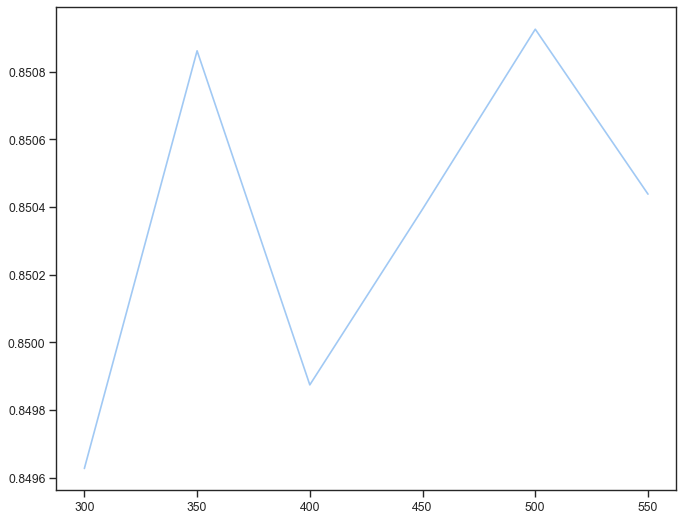

In [179]:
x = []
y1 = []
for num in range(300,600,50):
    model = RandomForestClassifier(n_estimators=num, max_depth=7)
    scores_target = cross_validation_for_roc_auc(model, train_final[features] , train_final['stroke'])
    x.append(num)
    y1.append(np.mean(scores_target))
    print(num, np.mean(scores_target))
fig, ax = plt.subplots(figsize=(10,8), dpi=80)
plt.plot(x, y1, label='target')
plt.show()

2 0.8396663094414102
3 0.8431890432222311
4 0.8453676265996682
5 0.8474218810645464
6 0.8500480010067453
7 0.8498448316742089
8 0.8492649106539171
9 0.8450442408230895


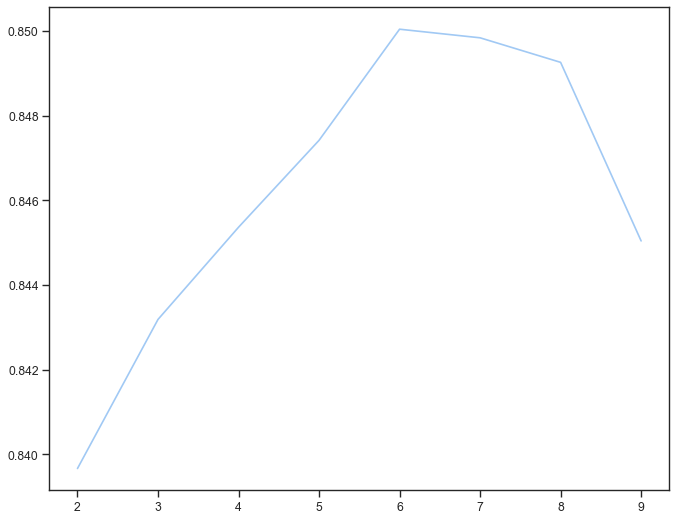

In [181]:
x = []
y1 = []
for num in range(2,10):
    model = RandomForestClassifier(n_estimators=500, max_depth=num)
    scores_target = cross_validation_for_roc_auc(model, train_final[features] , train_final['stroke'])
    x.append(num)
    y1.append(np.mean(scores_target))
    print(num, np.mean(scores_target))
fig, ax = plt.subplots(figsize=(10,8), dpi=80)
plt.plot(x, y1, label='target')
plt.show()

these plots are useless


2 0.8029451787356369
3 0.8271582768087452
4 0.8326587668542775
5 0.8268465590808016
6 0.8211850835543855
7 0.7877148677928114
8 0.7498007721829426
9 0.7288842045158546


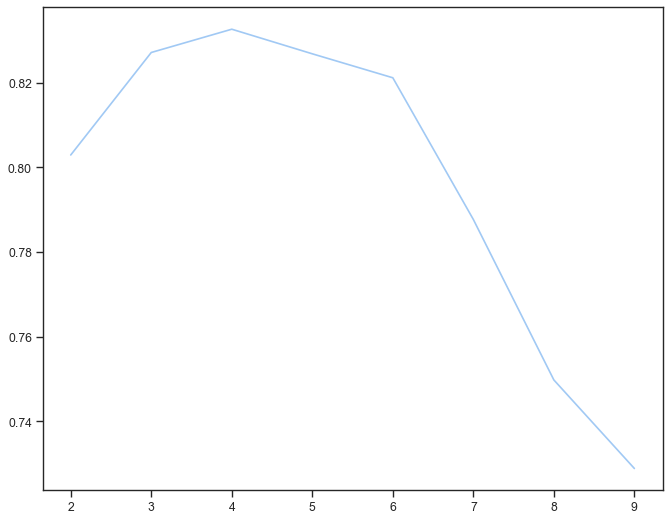

In [180]:


x = []
y1 = []
for num in range(2,10):
    model = DecisionTreeClassifier(max_depth=num)
    scores_target = cross_validation_for_roc_auc(model, train_final[features] , train_final['stroke'])
    x.append(num)
    y1.append(np.mean(scores_target))
    print(num, np.mean(scores_target))
fig, ax = plt.subplots(figsize=(10,8), dpi=80)
plt.plot(x, y1, label='target')
plt.show()


In [183]:
classif = RandomForestClassifier(n_estimators=500, max_depth=7)

classif.fit(train_final[features] , train_final['stroke'])
prediction = classif.predict_proba(test_new[features])[:,1]
sample['stroke'] = prediction

In [184]:
sample.to_csv('submission.csv', index = None )